In [1]:
import pandas as pd
import numpy as np
import datetime
import sklearn
from sklearn.model_selection import TimeSeriesSplit

from collections import Counter
from sklearn.base import BaseEstimator
from tqdm import trange
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
import copy

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.under_sampling import     OneSidedSelection 
from xgboost import XGBClassifier
from imblearn.under_sampling import ClusterCentroids 
from sklearn.preprocessing import StandardScaler

### Indexer

Модификация индексера - ансабль забывающих моделей.

In [2]:
class forget_model(BaseEstimator):
    def __init__(self, model=LogisticRegression(),n_splits=4, balance=None):
        self._models = [] # лист, в котором будут храниться обученные модели для каждого сплита
        self.n_splits = n_splits # число сплитов
        self.balance = balance # должен поддерживать большинство 
        # методов из imbalanced-learn, которые поддерживают fit_sample
        self._model = copy.copy(model) # модели, поддерживающие fit, predict и predict_proba
    
    # inputs - уникальные значения дат
    def _iterate_megabatches(self, inputs, n_splits): # делает разбиение по времени без пересечений
        batchsize = len(inputs)//n_splits
        for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
            excerpt = np.arange(start_idx, start_idx + batchsize)
            yield inputs[excerpt]
    
    # X - это весь датафрейм за два месяца ВМЕСТЕ с таргетом
    def fit(self, X, y):
        models = [] # пустой список моделей
        batch_df_i_neg = pd.DataFrame() # заготовки для не фрода в итом сплите
        batch_df_pos = pd.DataFrame() #  заготовка для фрода
        unique_TS_split = np.array(sorted(X.TS_indexer.unique())) # получаем число уникальных дат
        
        for train_index in self._iterate_megabatches(inputs=unique_TS_split, n_splits=self.n_splits): 
            batch_df_i_old_neg = batch_df_i_neg # сохраняем прошлуб базу не фрода
            batch_df_i = X[X.TS_indexer.isin(train_index)] # получаем базу данных итого сплита
            batch_df_i_pos = batch_df_i[batch_df_i.label==1] #  разбиваем ее на фрод
            batch_df_i_neg = batch_df_i[batch_df_i.label==0] #  и не фрод
            batch_df_pos = pd.concat([batch_df_pos, batch_df_i_pos]) # получаем данные не фрода для обучения
            batch_df_neg = pd.concat([batch_df_i_old_neg, batch_df_i_neg]) # получаем данные фрода для обучения
            df_i = pd.concat([batch_df_pos, batch_df_neg]) #  объединяем фрод и не фрод
            X_df_i = df_i.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1) #  выделяем обучение
            y_df_i = df_i.label #  и таргет
            if self.balance is None: #  без балансировки просто продолжаем
                pass
            else: 
                balancing = self.balance 
                X_df_balanced_i, y_df_balanced_i = balancing.fit_sample(X_df_i.values, y_df_i.values) # делаем перебалансировку
                X_df_i = X_df_balanced_i
                y_df_i = y_df_balanced_i

            model_i = copy.copy(self._model) # итая модель
            model_i.fit(X_df_i.values, y_df_i.values) # обучаем итую модель

            
            models.append(copy.copy(model_i)) #  сохраняем ее в лист
        self._models = copy.copy(models) #  возвращаем в селф


    def predict(self, X_test): 
        pr = np.zeros(len(X_test)) # заготовка
        if self.n_splits==1:
            predictions = self._models[0].predict(X_test)
        else:
            for model_i in self._models:
                pr_i = model_i.predict(X_test) # предсказания итой модели
                pr = np.vstack([pr,pr_i]) # объединяем предсказания
            predictions = np.array([Counter(x).most_common(1)[0][0] for x in pr[1:].T]) #  простое голосвание
        return predictions
    
    def predict_proba(self, X_test):
        pr = np.array([np.zeros(len(X_test))]*2).T #заготовка
        if self.n_splits==1:
            predictions = self._models[0].predict_proba(X_test)
        else:
            for model_i in self._models:
                pr_i = model_i.predict_proba(X_test) #  получаем вероятности итой модели
                pr = np.sum([pr, pr_i], axis = 0) 
            predictions = pr/len(self._models) #  получаем усредненные вероятности
        return predictions

Вспомогательная функция для разбиения на трейновую и валидационную выборки.

In [3]:
def train_val_ts_split(X, th=0.7, split_target=None): # X - датафрейм, в котором есть  TS_indexer
    unique_TS_split = np.array(sorted(X.TS_indexer.unique()))
    batchsize = int(len(unique_TS_split)*th)
    excerpt_train = np.arange(0, batchsize)
    excerpt_val =  np.arange(batchsize, len(unique_TS_split))
    d_train =  X[X.TS_indexer.isin(unique_TS_split[excerpt_train])]
    d_val = X[X.TS_indexer.isin(unique_TS_split[excerpt_val])]
    if split_target is None:
        return d_train, d_val
    else:
        return d_train.drop('label', axis=1), d_train.label, d_val.drop('label', axis=1), d_val.label

Загружаем данные с фичами и проводим предварительные преобразования.

In [4]:
data = pd.read_feather("../data/combined_dataset/train_v1.fth")

data['TS_indexer'] = data.short_date
data.fillna(0, inplace=True)
data.drop(['event_id', 'event_time'], axis = 1, inplace=True)

In [5]:
data = data[data.label>=0]

Разбиваем на трейн и валидацию.

In [6]:
X_train, X_val = train_val_ts_split(data , th=0.7, split_target=None)
y_val = X_val['label'].values
y_train = X_train['label']#.values
x_train = X_train.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1)

Сбросим индекс.

In [12]:
X_train_id = X_train.reset_index(drop=True)
X = X_train_id.drop(['user_id' ,'short_date','TS_indexer', 'label'], axis=1).as_matrix()

Проведем undersampling данных.

In [14]:
id_leg = X_train[X_train.label==0].user_id.unique()
id_leg_f = X_train[X_train.label==1].user_id.unique()
sample_leg = np.random.choice(id_leg, len(id_leg)//20)
sample = np.append(sample_leg, id_leg_f)
X_train_sampled = X_train[X_train.user_id.isin(sample)]
y_train_sampled = y_train.loc[X_train_sampled.index].values

In [15]:
y_train = y_train.values

### Sampling и сравнение результатов

Обучим стандартный градиентный бустинг с заранее подобранными параметрами.

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200,
       objective='binary:logistic', reg_alpha=8, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6, n_jobs=16)
xgb.fit(X ,y_train)

preds_proba = xgb.predict_proba(X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).values
                             )
preds = xgb.predict(X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).values
                 )

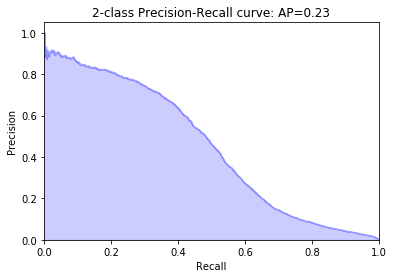

Precision-Recall AUC: AP=0.4518


In [21]:
average_precision = average_precision_score(y_val, preds)
precision, recall, thresholds = precision_recall_curve(y_val, preds_proba[:, 1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

auc = metrics.auc(recall, precision)
print('Precision-Recall AUC: AP={0:0.4f}'.format(
          auc))

Градиентный бустинг с весами классов:

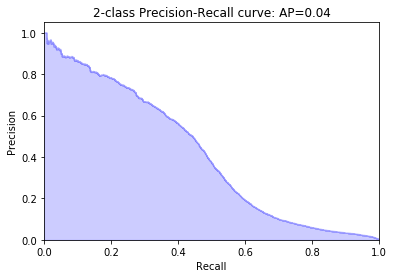

Precision-Recall AUC: AP=0.4120


In [34]:
xgb4 = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200,
       objective='binary:logistic', reg_alpha=8, reg_lambda=1,
       scale_pos_weight=sum(y_train==0)/sum(y_train==1),
                     seed=0, silent=True, subsample=0.6, n_jobs=16)

xgb4.fit(X ,y_train)
preds_proba6 = xgb4.predict_proba(X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).values
                             )
preds6 = xgb4.predict(X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).values
                    )

average_precision6 = average_precision_score(y_val, preds6)
precision6, recall6, thresholds6 = precision_recall_curve(y_val, preds_proba6[:, 1])

plt.step(recall6, precision6, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall6, precision6, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision6))
plt.show()

auc6 = metrics.auc(recall6, precision6)
print('Precision-Recall AUC: AP={0:0.4f}'.format(
          auc6))

Градиентный бустинг при андерсэмплинге:

In [22]:
X_sampled = X_train_sampled.drop(['user_id' ,'short_date','TS_indexer', 'label'], axis=1).as_matrix()

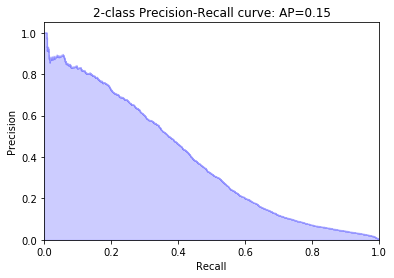

Precision-Recall AUC: AP=0.3843


In [23]:
xgb2 = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200,
       objective='binary:logistic', reg_alpha=8, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6, n_jobs=16)

xgb2.fit(X_sampled ,y_train_sampled)
preds_proba2 = xgb2.predict_proba(X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).values
                             )
preds2 = xgb2.predict(X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).values
                    )

average_precision2 = average_precision_score(y_val, preds2)
precision2, recall2, thresholds2 = precision_recall_curve(y_val, preds_proba2[:, 1])



plt.step(recall2, precision2, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall2, precision2, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision2))
plt.show()

auc2 = metrics.auc(recall2, precision2)
print('Precision-Recall AUC: AP={0:0.4f}'.format(
          auc2))

#### SMOTETomek не работает с очень большими объемами данных, поэтому предварительно был уменьшен размер легитимного класса

Градиентный бустинг при андерсэмплинге + SMOTETomek:

In [24]:
smotek = SMOTETomek(random_state=42, n_jobs = 10)

xgb3 = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200,
       objective='binary:logistic', reg_alpha=8, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6, n_jobs=16)

smotkxgb = Pipeline([('smt', smotek), ('xgb', xgb3)] 
                    ,memory="../data/cashed_gs/" 
                   )

In [25]:
smotkxgb.fit(X_sampled ,y_train_sampled)

/anaconda3/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


Pipeline(memory='../data/cashed_gs/',
     steps=[('smt', SMOTETomek(k=5, kind_smote='regular', m=10, n_jobs=10, out_step=0.5,
      random_state=42, ratio='auto', smote=None, tomek=None)), ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
 ...state=0, reg_alpha=8, reg_lambda=1, scale_pos_weight=1,
       seed=0, silent=True, subsample=0.6))])

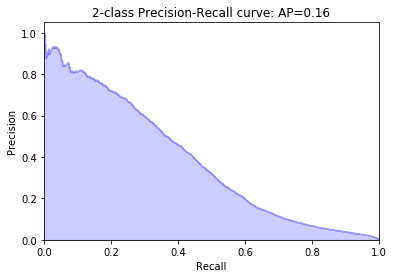

Precision-Recall AUC: AP=0.3804


In [26]:
preds_proba3 = smotkxgb.predict_proba(X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).values
                             )
preds3 = smotkxgb.predict(X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).values
                    )

average_precision3 = average_precision_score(y_val, preds3)
precision3, recall3, thresholds3 = precision_recall_curve(y_val, preds_proba3[:, 1])



plt.step(recall3, precision3, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall3, precision3, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision3))
plt.show()

auc3 = metrics.auc(recall3, precision3)
print('Precision-Recall AUC: AP={0:0.4f}'.format(
          auc3))

Забывающая модель:

100%|██████████| 2/2 [07:14<00:00, 217.33s/it]


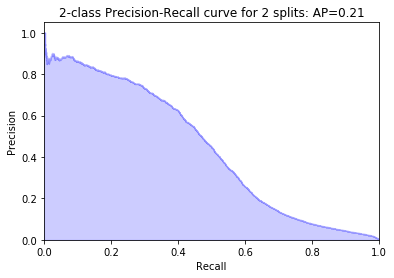

Precision-Recall AUC: AP=0.4420


In [27]:
model_f = forget_model(model=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200,
       objective='binary:logistic', reg_alpha=8, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6, n_jobs=16),
                       n_splits=2)

model_f.fit(X_train, y_train)
preds_proba4 = model_f.predict_proba(X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).values
                             )
preds4 = model_f.predict(X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).values
                 )
average_precision4 = average_precision_score(y_val, preds4)
precision4, recall4, thresholds4 = precision_recall_curve(y_val, preds_proba4[:, 1])



plt.step(recall4, precision4, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall4, precision4, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve for 2 splits: AP={0:0.2f}'.format(
          average_precision4))
plt.show()

auc4 = metrics.auc(recall4, precision4)
print('Precision-Recall AUC: AP={0:0.4f}'.format(
          auc4))

100%|██████████| 5/5 [08:18<00:00, 99.77s/it]


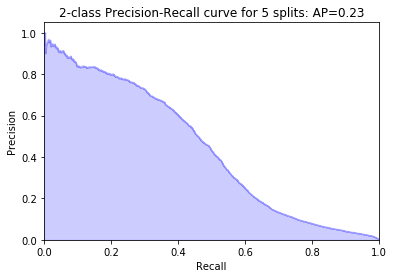

Precision-Recall AUC: AP=0.4397


In [29]:
model_f = forget_model(model=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200,
       objective='binary:logistic', reg_alpha=8, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6, n_jobs=16),
                       n_splits=5)

model_f.fit(X_train, y_train)
preds_proba5 = model_f.predict_proba(X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).values
                             )
preds5 = model_f.predict(X_val.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1).values
                 )
average_precision5 = average_precision_score(y_val, preds5)
precision5, recall5, thresholds5 = precision_recall_curve(y_val, preds_proba5[:, 1])



plt.step(recall5, precision5, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall5, precision5, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve for 5 splits: AP={0:0.2f}'.format(
          average_precision5))
plt.show()

auc5 = metrics.auc(recall5, precision5)
print('Precision-Recall AUC: AP={0:0.4f}'.format(
          auc5))

In [36]:
result_df = pd.DataFrame(columns=['Average precision', 'Pr-R AUC'],
                         index = ['xgb', 'xgb + class weight', 'undersampling xgb',
                                  'undersampling + smotek xgb', 'forget model 2 splits', 'forget model 5 splits'])

In [38]:
result_df.iloc[0] = [average_precision, auc]
result_df.iloc[1] = [average_precision6, auc6]
result_df.iloc[2] = [average_precision2, auc2]
result_df.iloc[3] = [average_precision3, auc3]
result_df.iloc[4] = [average_precision4, auc4]
result_df.iloc[5] = [average_precision5, auc5]

In [39]:
result_df

,Average precision,Pr-R AUC
xgb,0.227182,0.451754
xgb + class weight,0.0433926,0.412033
undersampling xgb,0.152812,0.384326
undersampling + smotek xgb,0.155021,0.380389
forget model 2 splits,0.212485,0.441986
forget model 5 splits,0.231636,0.439691


Из таблицы с результатами видно, что лучше всего себя показал обычный градиентный бустинг без каких-либо манипуляций с размерами классов.